Trade Statistics with Weighted Scaled Score, Backtest Run, and Parameters:
    backtest_run  metric_threshold  min_bars_apart  num_trades  winrate_pct  \
0             1               0.3              50          12         25.0   

   return_pct  max_drawdown_pct  weighted_scaled_s  
0       65.79             22.91             0.5596  
Raw Trades:
     type            entry_dt  entry_price           SL       size  \
0   sell 2025-12-05 02:33:00  4196.818743  4199.818743  16.666667   
1    buy 2025-12-05 02:36:00  4200.014975  4197.014975  15.542246   
2    buy 2025-12-05 05:45:00  4222.379779  4219.379779  20.638931   
3   sell 2025-12-05 05:45:00  4217.035430  4220.035430  20.638931   
4   sell 2025-12-05 13:06:00  4222.854194  4225.854194  17.361877   
5    buy 2025-12-05 13:09:00  4227.765470  4224.765470  15.910482   
6    buy 2025-12-05 15:36:00  4254.930791  4251.930791  22.725994   
7   sell 2025-12-05 15:45:00  4250.872333  4253.872333  20.839002   
8   sell 2025-12-05 18:27:0

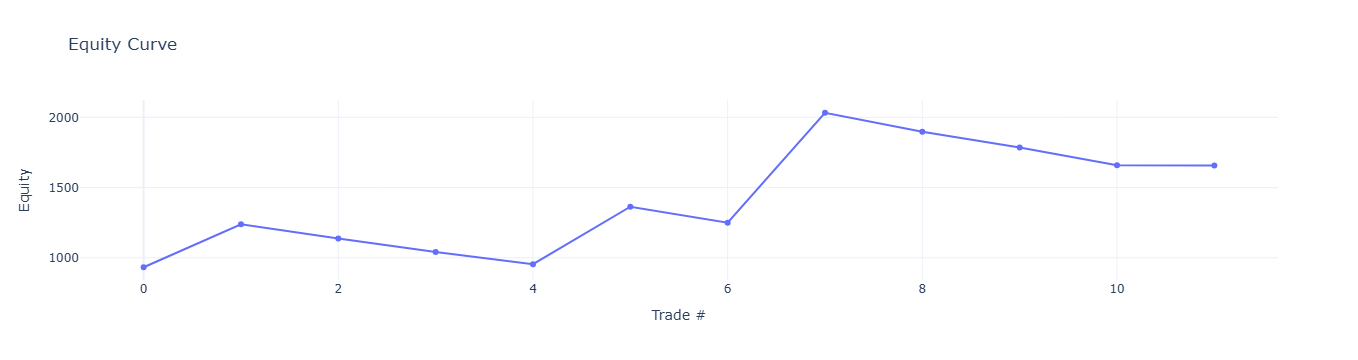

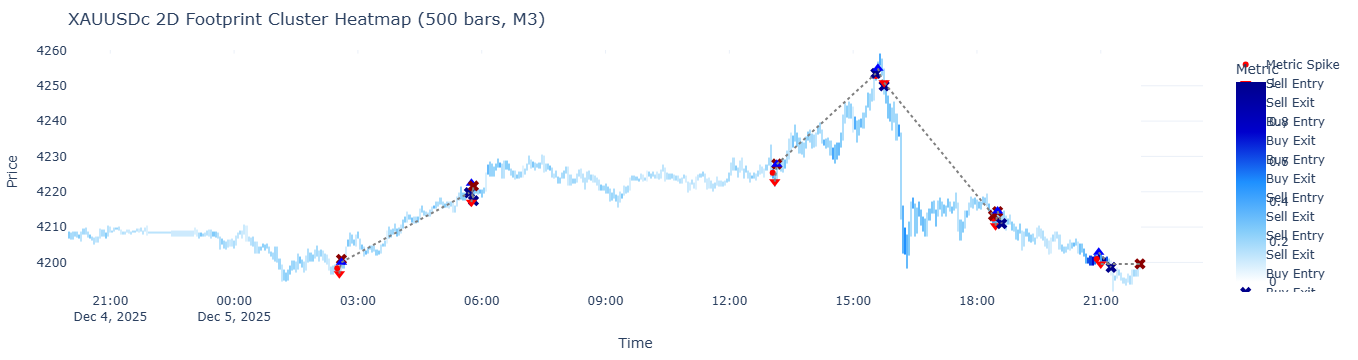

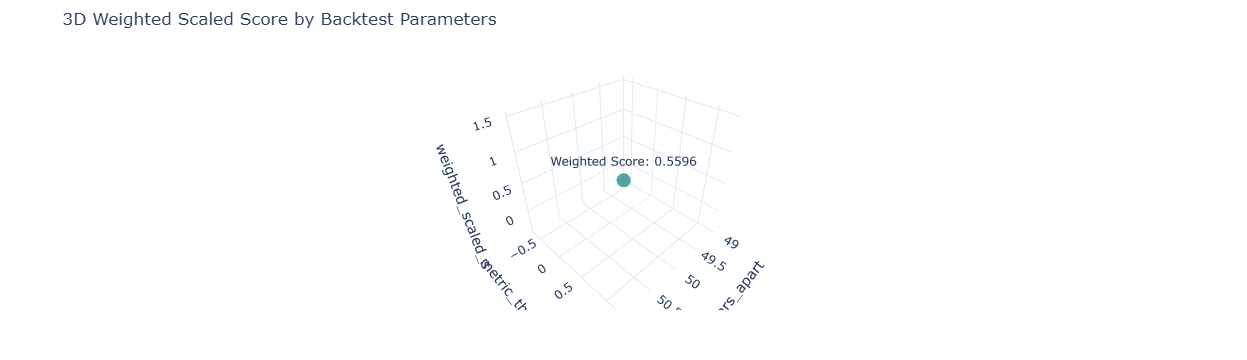

Monte Carlo Simulation Trade Statistics (Weighted Mean):
    metric_threshold  min_bars_apart  num_trades  winrate_pct  return_pct  \
0               0.3              50        12.0    22.666667   42.578705   

   max_drawdown_pct  weighted_scaled_s  
0         25.147597           0.468173  
Monte Carlo Simulation Raw Trades (All Runs Concatenated):
       type            entry_dt  entry_price           SL       size  \
0     sell 2025-12-05 02:33:00  4195.859681  4198.859681  16.666667   
1      buy 2025-12-05 02:36:00  4199.993739  4196.993739  15.397783   
2      buy 2025-12-05 05:45:00  4222.069057  4219.069057  20.345880   
3     sell 2025-12-05 05:45:00  4217.512418  4220.512418  20.345880   
4     sell 2025-12-05 13:06:00  4223.574554  4226.574554  16.858028   
...    ...                 ...          ...          ...        ...   
1195  sell 2025-12-05 15:45:00  4249.348002  4252.348002  15.149923   
1196  sell 2025-12-05 18:27:00  4210.159831  4213.159831  24.594237   
1197   b

In [2]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import random

# -------------------------------
# Parameters / Risk & Stress
# -------------------------------
cluster_size = 0.25
metric_threshold = 0.3
min_bars_apart = 50
SL_UNITS = 3.0
SPREAD = 0.6
COMMISSION = 0.02
SLIPPAGE_MAX = 2.0
START_CAPITAL = 1000.0
RISK_PCT = 0.05  # 5% risk per trade

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500

# -------------------------------
# 2. Fetch historical data
# -------------------------------
now = pd.to_datetime("now")
rates = mt5.copy_rates_from(symbol, timeframe, now, num_bars)
if rates is None or len(rates) == 0:
    print("No data returned from MT5.")
    mt5.shutdown()
    quit()

df = pd.DataFrame(rates)
df["datetime"] = pd.to_datetime(df["time"], unit="s")
df["center"] = (df["high"] + df["low"]) / 2

# -------------------------------
# 3. Build 0.25 footprint clusters
# -------------------------------
df["low_cluster"] = np.floor(df["low"] / cluster_size) * cluster_size
df["high_cluster"] = np.floor(df["high"] / cluster_size) * cluster_size

cluster_rows = []
for i in range(len(df)):
    low = df["low_cluster"].iloc[i]
    high = df["high_cluster"].iloc[i]
    vol = df["tick_volume"].iloc[i]
    dt = df["datetime"].iloc[i]
    price_levels = np.arange(low, high + cluster_size, cluster_size)
    n_levels = len(price_levels) if len(price_levels) > 0 else 1
    for p in price_levels:
        cluster_rows.append([dt, p, vol / n_levels])

cluster_df = pd.DataFrame(cluster_rows, columns=["datetime", "price", "cluster_vol"])

# -------------------------------
# 4. Metric scale & spike detection
# -------------------------------
max_vol = cluster_df["cluster_vol"].max() if not cluster_df.empty else 1.0
cluster_df["metric"] = cluster_df["cluster_vol"] / max_vol

metric_by_dt = cluster_df.groupby("datetime")["metric"].max().to_dict()
df["raw_metric_spike"] = df["datetime"].apply(lambda dt: metric_by_dt.get(dt, 0.0) >= metric_threshold)

df["metric_spike"] = False
last_spike_idx = -min_bars_apart
for i in range(len(df)):
    if df["raw_metric_spike"].iloc[i] and (i - last_spike_idx) >= min_bars_apart:
        df.at[i, "metric_spike"] = True
        last_spike_idx = i

# -------------------------------
# 5. Trading framework with pending orders & risk-based sizing
# -------------------------------
capital = START_CAPITAL
trades = []

pending_buy = None
pending_sell = None
active_buy = None
active_sell = None

for i in range(len(df)):
    row = df.iloc[i]
    dt = row["datetime"]
    high = row["high"]
    low = row["low"]
    center = row["center"]

    # ------------------------
    # Check active trades for stoploss / takeprofit
    # ------------------------
    for trade_list, direction in [(active_buy, "buy"), (active_sell, "sell")]:
        trade = trade_list
        if trade:
            if trade["type"] == "buy":
                if low <= trade["SL"]:  # stoploss
                    exit_price = trade["SL"] - SPREAD/2 - random.uniform(0, SLIPPAGE_MAX)
                    pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                    capital += pnl
                    trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "stoploss"})
                    trades.append(trade)
                    active_buy = None
                elif row["metric_spike"]:  # takeprofit at next spike
                    exit_price = high - SPREAD/2 - random.uniform(0, SLIPPAGE_MAX)
                    pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                    capital += pnl
                    trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "takeprofit"})
                    trades.append(trade)
                    active_buy = None
            elif trade["type"] == "sell":
                if high >= trade["SL"]:  # stoploss
                    exit_price = trade["SL"] + SPREAD/2 + random.uniform(0, SLIPPAGE_MAX)
                    pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                    capital += pnl
                    trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "stoploss"})
                    trades.append(trade)
                    active_sell = None
                elif row["metric_spike"]:  # takeprofit at next spike
                    exit_price = low + SPREAD/2 + random.uniform(0, SLIPPAGE_MAX)
                    pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                    capital += pnl
                    trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "takeprofit"})
                    trades.append(trade)
                    active_sell = None

    # ------------------------
    # Check pending orders for execution
    # ------------------------
    if pending_buy and not active_buy:
        if high >= pending_buy["price"]:
            entry_price = pending_buy["price"] + SPREAD/2 + random.uniform(0, SLIPPAGE_MAX)
            size = (capital * RISK_PCT) / SL_UNITS
            active_buy = {"type": "buy", "entry_dt": dt, "entry_price": entry_price,
                          "SL": entry_price - SL_UNITS, "size": size}
            pending_buy = None
    if pending_sell and not active_sell:
        if low <= pending_sell["price"]:
            entry_price = pending_sell["price"] - SPREAD/2 - random.uniform(0, SLIPPAGE_MAX)
            size = (capital * RISK_PCT) / SL_UNITS
            active_sell = {"type": "sell", "entry_dt": dt, "entry_price": entry_price,
                           "SL": entry_price + SL_UNITS, "size": size}
            pending_sell = None

    # ------------------------
    # Generate new pending orders
    # ------------------------
    if row["metric_spike"]:
        pending_buy = {"price": high, "dt": dt}
        pending_sell = {"price": low, "dt": dt}

# Close remaining trades at last bar
last_dt = df["datetime"].iloc[-1]
for trade in [active_buy, active_sell]:
    if trade:
        exit_price = df["center"].iloc[-1]
        slippage = random.uniform(0, SLIPPAGE_MAX)
        if trade["type"] == "buy":
            exit_price -= SPREAD/2 + slippage
            pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
        else:
            exit_price += SPREAD/2 + slippage
            pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
        capital += pnl
        trade.update({"exit_dt": last_dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "end"})
        trades.append(trade)

trades_df = pd.DataFrame(trades)

# -------------------------------
# 6. Trade Statistics with weighted_scaled_s, backtest_run, and parameters
# -------------------------------
trades_df["cum_equity"] = trades_df["PnL"].cumsum() + START_CAPITAL

num_trades = len(trades_df)
win_trades = trades_df[trades_df["PnL"] > 0]

winrate_pct = (len(win_trades) / num_trades * 100) if num_trades > 0 else 0
return_pct = (trades_df["cum_equity"].iloc[-1] - START_CAPITAL) / START_CAPITAL * 100

cum_max = trades_df["cum_equity"].cummax()
drawdowns = (trades_df["cum_equity"] - cum_max) / cum_max * 100
max_drawdown_pct = abs(drawdowns.min())

scaled_winrate = np.clip(winrate_pct / 100, 0, 1)
scaled_return = np.clip(return_pct / 100, 0, 1)
scaled_maxdrawdown = np.clip(1 - (max_drawdown_pct / 100), 0, 1)

weighted_scaled_s = (scaled_winrate + scaled_return + scaled_maxdrawdown) / 3

stat_df = pd.DataFrame([{
    "backtest_run": 1,
    "metric_threshold": metric_threshold,
    "min_bars_apart": min_bars_apart,
    "num_trades": num_trades,
    "winrate_pct": round(winrate_pct, 2),
    "return_pct": round(return_pct, 2),
    "max_drawdown_pct": round(max_drawdown_pct, 2),
    "weighted_scaled_s": round(weighted_scaled_s, 4)
}])

print("Trade Statistics with Weighted Scaled Score, Backtest Run, and Parameters:\n", stat_df)
print("Raw Trades:\n", trades_df)

# -------------------------------
# 7. Equity Curve Plot
# -------------------------------
fig_eq = go.Figure()
fig_eq.add_trace(go.Scatter(
    x=list(range(len(trades_df))),
    y=trades_df["cum_equity"],
    mode="lines+markers",
    name="Equity"
))
fig_eq.update_layout(
    title="Equity Curve",
    xaxis_title="Trade #",
    yaxis_title="Equity",
    template="plotly_white"
)
fig_eq.show()

# -------------------------------
# 8. 2D Footprint Heatmap
# -------------------------------
colorscale = [
    [0.0, "white"],
    [0.25, "#87CEFA"],
    [0.50, "#1E90FF"],
    [0.75, "#0000CD"],
    [1.0, "#00008B"],
]

heatmap_df = cluster_df.pivot_table(index="price", columns="datetime", values="metric", fill_value=0)
fig = px.imshow(
    heatmap_df,
    aspect="auto",
    origin="lower",
    color_continuous_scale=colorscale,
    labels=dict(x="Time", y="Price", color="Metric"),
    template="plotly_white"
)

spike_df = df[df["metric_spike"]]
fig.add_scatter(
    x=spike_df["datetime"],
    y=spike_df["center"],
    mode="markers",
    marker=dict(color="red", size=6),
    name="Metric Spike"
)

for idx, trade in trades_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[trade["entry_dt"]],
        y=[trade["entry_price"]],
        mode="markers",
        marker=dict(symbol="triangle-up" if trade["type"]=="buy" else "triangle-down",
                    size=10, color="blue" if trade["type"]=="buy" else "red"),
        name=f'{trade["type"].capitalize()} Entry'
    ))
    fig.add_trace(go.Scatter(
        x=[trade["exit_dt"]],
        y=[trade["exit_price"]],
        mode="markers",
        marker=dict(symbol="x", size=10, color="darkblue" if trade["type"]=="buy" else "darkred"),
        name=f'{trade["type"].capitalize()} Exit'
    ))
    fig.add_trace(go.Scatter(
        x=[trade["entry_dt"], trade["exit_dt"]],
        y=[trade["entry_price"], trade["exit_price"]],
        mode="lines",
        line=dict(dash="dot", color="gray"),
        showlegend=False
    ))

fig.update_layout(
    title=f"XAUUSDc 2D Footprint Cluster Heatmap ({num_bars} bars, M3)",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis=dict(type='date'),
    template="plotly_white",
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()

# -------------------------------
# 9. 3D Weighted Scaled Score Visualization
# -------------------------------
fig_3d = go.Figure()

fig_3d.add_trace(go.Scatter3d(
    x=stat_df["min_bars_apart"],
    y=stat_df["metric_threshold"],
    z=stat_df["weighted_scaled_s"],
    mode='markers+text',
    marker=dict(
        size=8,
        color=stat_df["weighted_scaled_s"],  # color by score
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f"Weighted Score: {s}" for s in stat_df["weighted_scaled_s"]],
    textposition="top center"
))

fig_3d.update_layout(
    title="3D Weighted Scaled Score by Backtest Parameters",
    scene=dict(
        xaxis_title='min_bars_apart',
        yaxis_title='metric_threshold',
        zaxis_title='weighted_scaled_s'
    ),
    template="plotly_white",
    margin=dict(l=50, r=50, t=50, b=50)
)

fig_3d.show()

# -------------------------------
# 10. Monte Carlo Simulation
# -------------------------------
MC_RUNS = 100
all_stats = []
all_raw_trades = []

for mc in range(MC_RUNS):
    # Reset capital for each run
    capital_mc = START_CAPITAL
    trades_mc = []
    pending_buy_mc = None
    pending_sell_mc = None
    active_buy_mc = None
    active_sell_mc = None

    for i in range(len(df)):
        row = df.iloc[i]
        dt = row["datetime"]
        high = row["high"]
        low = row["low"]
        center = row["center"]

        # Check active trades for stoploss / takeprofit
        for trade_list, direction in [(active_buy_mc, "buy"), (active_sell_mc, "sell")]:
            trade = trade_list
            if trade:
                slippage = random.uniform(0, SLIPPAGE_MAX)
                if trade["type"] == "buy":
                    if low <= trade["SL"]:  # stoploss
                        exit_price = trade["SL"] - SPREAD/2 - slippage
                        pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                        capital_mc += pnl
                        trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "stoploss"})
                        trades_mc.append(trade)
                        active_buy_mc = None
                    elif row["metric_spike"]:  # takeprofit
                        exit_price = high - SPREAD/2 - slippage
                        pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                        capital_mc += pnl
                        trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "takeprofit"})
                        trades_mc.append(trade)
                        active_buy_mc = None
                else:  # sell
                    if high >= trade["SL"]:  # stoploss
                        exit_price = trade["SL"] + SPREAD/2 + slippage
                        pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                        capital_mc += pnl
                        trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "stoploss"})
                        trades_mc.append(trade)
                        active_sell_mc = None
                    elif row["metric_spike"]:  # takeprofit
                        exit_price = low + SPREAD/2 + slippage
                        pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                        capital_mc += pnl
                        trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "takeprofit"})
                        trades_mc.append(trade)
                        active_sell_mc = None

        # Pending orders execution
        if pending_buy_mc and not active_buy_mc and high >= pending_buy_mc["price"]:
            entry_price = pending_buy_mc["price"] + SPREAD/2 + random.uniform(0, SLIPPAGE_MAX)
            size = (capital_mc * RISK_PCT) / SL_UNITS
            active_buy_mc = {"type": "buy", "entry_dt": dt, "entry_price": entry_price,
                             "SL": entry_price - SL_UNITS, "size": size}
            pending_buy_mc = None

        if pending_sell_mc and not active_sell_mc and low <= pending_sell_mc["price"]:
            entry_price = pending_sell_mc["price"] - SPREAD/2 - random.uniform(0, SLIPPAGE_MAX)
            size = (capital_mc * RISK_PCT) / SL_UNITS
            active_sell_mc = {"type": "sell", "entry_dt": dt, "entry_price": entry_price,
                              "SL": entry_price + SL_UNITS, "size": size}
            pending_sell_mc = None

        # Generate new pending orders
        if row["metric_spike"]:
            pending_buy_mc = {"price": high, "dt": dt}
            pending_sell_mc = {"price": low, "dt": dt}

    # Close remaining trades at last bar
    last_dt = df["datetime"].iloc[-1]
    for trade in [active_buy_mc, active_sell_mc]:
        if trade:
            slippage = random.uniform(0, SLIPPAGE_MAX)
            exit_price = df["center"].iloc[-1]
            if trade["type"] == "buy":
                exit_price -= SPREAD/2 + slippage
                pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
            else:
                exit_price += SPREAD/2 + slippage
                pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
            capital_mc += pnl
            trade.update({"exit_dt": last_dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "end"})
            trades_mc.append(trade)

    trades_mc_df = pd.DataFrame(trades_mc)
    trades_mc_df["cum_equity"] = trades_mc_df["PnL"].cumsum() + START_CAPITAL
    all_raw_trades.append(trades_mc_df)

    # Trade statistics
    num_trades = len(trades_mc_df)
    win_trades = trades_mc_df[trades_mc_df["PnL"] > 0]
    winrate_pct = (len(win_trades) / num_trades * 100) if num_trades > 0 else 0
    return_pct = (trades_mc_df["cum_equity"].iloc[-1] - START_CAPITAL) / START_CAPITAL * 100
    cum_max = trades_mc_df["cum_equity"].cummax()
    drawdowns = (trades_mc_df["cum_equity"] - cum_max) / cum_max * 100
    max_drawdown_pct = abs(drawdowns.min())
    scaled_winrate = np.clip(winrate_pct / 100, 0, 1)
    scaled_return = np.clip(return_pct / 100, 0, 1)
    scaled_maxdrawdown = np.clip(1 - (max_drawdown_pct / 100), 0, 1)
    weighted_scaled_s = (scaled_winrate + scaled_return + scaled_maxdrawdown) / 3

    all_stats.append({
        "backtest_run": mc + 1,
        "metric_threshold": metric_threshold,
        "min_bars_apart": min_bars_apart,
        "num_trades": num_trades,
        "winrate_pct": winrate_pct,
        "return_pct": return_pct,
        "max_drawdown_pct": max_drawdown_pct,
        "weighted_scaled_s": weighted_scaled_s
    })

# -------------------------------
# Weighted / averaged Monte Carlo results
# -------------------------------
mc_stat_df = pd.DataFrame(all_stats)
mc_raw_trades_df = pd.concat(all_raw_trades, ignore_index=True)

# Weighted mean version of trade statistics
weighted_mc_stat_df = mc_stat_df.groupby(["metric_threshold", "min_bars_apart"]).agg({
    "num_trades": "mean",
    "winrate_pct": "mean",
    "return_pct": "mean",
    "max_drawdown_pct": "mean",
    "weighted_scaled_s": "mean"
}).reset_index()

print("Monte Carlo Simulation Trade Statistics (Weighted Mean):\n", weighted_mc_stat_df)
print("Monte Carlo Simulation Raw Trades (All Runs Concatenated):\n", mc_raw_trades_df)



calculated the total number of possible combination pair from one metric_treshold (0.05, 0.1, 0.15, ..., 1) and one min_bars_apart (1, 2, 3, ..., 100). Run monte carlo simulation 100 runs for each pair. And distribute all data inside the 'Monte Carlo Simulation Trade Statistics (Weighted Mean):' data frame section accounting only trade statistics. You do not need to plot the graphs other than printing the said dataframe section. Also download the trade statistics dataframe into csv file.

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime
import random

# -------------------------------
# Parameters / Risk & Stress
# -------------------------------
cluster_size = 0.25
SL_UNITS = 3.0
SPREAD = 0.6
COMMISSION = 0.02
SLIPPAGE_MAX = 2.0
START_CAPITAL = 1000.0
RISK_PCT = 0.05  # 5% risk per trade

# -------------------------------
# Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500

# -------------------------------
# Fetch historical data
# -------------------------------
now = pd.to_datetime("now")
rates = mt5.copy_rates_from(symbol, timeframe, now, num_bars)
if rates is None or len(rates) == 0:
    print("No data returned from MT5.")
    mt5.shutdown()
    quit()

df = pd.DataFrame(rates)
df["datetime"] = pd.to_datetime(df["time"], unit="s")
df["center"] = (df["high"] + df["low"]) / 2

# -------------------------------
# Build footprint clusters
# -------------------------------
df["low_cluster"] = np.floor(df["low"] / cluster_size) * cluster_size
df["high_cluster"] = np.floor(df["high"] / cluster_size) * cluster_size

cluster_rows = []
for i in range(len(df)):
    low = df["low_cluster"].iloc[i]
    high = df["high_cluster"].iloc[i]
    vol = df["tick_volume"].iloc[i]
    dt = df["datetime"].iloc[i]
    price_levels = np.arange(low, high + cluster_size, cluster_size)
    n_levels = len(price_levels) if len(price_levels) > 0 else 1
    for p in price_levels:
        cluster_rows.append([dt, p, vol / n_levels])

cluster_df = pd.DataFrame(cluster_rows, columns=["datetime", "price", "cluster_vol"])
max_vol = cluster_df["cluster_vol"].max() if not cluster_df.empty else 1.0
cluster_df["metric"] = cluster_df["cluster_vol"] / max_vol
metric_by_dt = cluster_df.groupby("datetime")["metric"].max().to_dict()
df["raw_metric_spike"] = df["datetime"].apply(lambda dt: metric_by_dt.get(dt, 0.0))

# -------------------------------
# Metric threshold and min_bars_apart grids
# -------------------------------
metric_thresholds = np.arange(0.05, 1.05, 0.05)
min_bars_aparts = np.arange(1, 101, 1)

MC_RUNS = 100
weighted_results = []

# -------------------------------
# Loop over all parameter pairs
# -------------------------------
for metric_threshold in metric_thresholds:
    for min_bars_apart in min_bars_aparts:
        all_stats = []

        # Compute metric spike flags for this pair
        df["metric_spike"] = False
        last_spike_idx = -min_bars_apart
        for i in range(len(df)):
            if df["raw_metric_spike"].iloc[i] >= metric_threshold and (i - last_spike_idx) >= min_bars_apart:
                df.at[i, "metric_spike"] = True
                last_spike_idx = i

        # Monte Carlo simulation
        for mc in range(MC_RUNS):
            capital_mc = START_CAPITAL
            trades_mc = []
            pending_buy_mc = None
            pending_sell_mc = None
            active_buy_mc = None
            active_sell_mc = None

            for i in range(len(df)):
                row = df.iloc[i]
                dt = row["datetime"]
                high = row["high"]
                low = row["low"]
                center = row["center"]

                # ------------------------
                # Check active trades for stoploss / takeprofit
                # ------------------------
                for trade_list, direction in [(active_buy_mc, "buy"), (active_sell_mc, "sell")]:
                    trade = trade_list
                    if trade:
                        slippage = random.uniform(0, SLIPPAGE_MAX)
                        if trade["type"] == "buy":
                            if low <= trade["SL"]:
                                exit_price = trade["SL"] - SPREAD/2 - slippage
                                pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                                capital_mc += pnl
                                trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "stoploss"})
                                trades_mc.append(trade)
                                active_buy_mc = None
                            elif row["metric_spike"]:
                                exit_price = high - SPREAD/2 - slippage
                                pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                                capital_mc += pnl
                                trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "takeprofit"})
                                trades_mc.append(trade)
                                active_buy_mc = None
                        else:
                            if high >= trade["SL"]:
                                exit_price = trade["SL"] + SPREAD/2 + slippage
                                pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                                capital_mc += pnl
                                trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "stoploss"})
                                trades_mc.append(trade)
                                active_sell_mc = None
                            elif row["metric_spike"]:
                                exit_price = low + SPREAD/2 + slippage
                                pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                                capital_mc += pnl
                                trade.update({"exit_dt": dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "takeprofit"})
                                trades_mc.append(trade)
                                active_sell_mc = None

                # Pending orders execution
                if pending_buy_mc and not active_buy_mc and high >= pending_buy_mc["price"]:
                    entry_price = pending_buy_mc["price"] + SPREAD/2 + random.uniform(0, SLIPPAGE_MAX)
                    size = (capital_mc * RISK_PCT) / SL_UNITS
                    active_buy_mc = {"type": "buy", "entry_dt": dt, "entry_price": entry_price,
                                     "SL": entry_price - SL_UNITS, "size": size}
                    pending_buy_mc = None

                if pending_sell_mc and not active_sell_mc and low <= pending_sell_mc["price"]:
                    entry_price = pending_sell_mc["price"] - SPREAD/2 - random.uniform(0, SLIPPAGE_MAX)
                    size = (capital_mc * RISK_PCT) / SL_UNITS
                    active_sell_mc = {"type": "sell", "entry_dt": dt, "entry_price": entry_price,
                                      "SL": entry_price + SL_UNITS, "size": size}
                    pending_sell_mc = None

                if row["metric_spike"]:
                    pending_buy_mc = {"price": high, "dt": dt}
                    pending_sell_mc = {"price": low, "dt": dt}

            # Close remaining trades at last bar
            last_dt = df["datetime"].iloc[-1]
            for trade in [active_buy_mc, active_sell_mc]:
                if trade:
                    slippage = random.uniform(0, SLIPPAGE_MAX)
                    exit_price = df["center"].iloc[-1]
                    if trade["type"] == "buy":
                        exit_price -= SPREAD/2 + slippage
                        pnl = trade["size"] * (exit_price - trade["entry_price"]) - COMMISSION * abs(exit_price - trade["entry_price"])
                    else:
                        exit_price += SPREAD/2 + slippage
                        pnl = trade["size"] * (trade["entry_price"] - exit_price) - COMMISSION * abs(trade["entry_price"] - exit_price)
                    capital_mc += pnl
                    trade.update({"exit_dt": last_dt, "exit_price": exit_price, "PnL": pnl, "exit_type": "end"})
                    trades_mc.append(trade)

            trades_mc_df = pd.DataFrame(trades_mc)
            trades_mc_df["cum_equity"] = trades_mc_df["PnL"].cumsum() + START_CAPITAL

            # Trade statistics
            num_trades = len(trades_mc_df)
            win_trades = trades_mc_df[trades_mc_df["PnL"] > 0]
            winrate_pct = (len(win_trades) / num_trades * 100) if num_trades > 0 else 0
            return_pct = (trades_mc_df["cum_equity"].iloc[-1] - START_CAPITAL) / START_CAPITAL * 100
            cum_max = trades_mc_df["cum_equity"].cummax()
            drawdowns = (trades_mc_df["cum_equity"] - cum_max) / cum_max * 100
            max_drawdown_pct = abs(drawdowns.min())
            scaled_winrate = np.clip(winrate_pct / 100, 0, 1)
            scaled_return = np.clip(return_pct / 100, 0, 1)
            scaled_maxdrawdown = np.clip(1 - (max_drawdown_pct / 100), 0, 1)
            weighted_scaled_s = (scaled_winrate + scaled_return + scaled_maxdrawdown) / 3

            all_stats.append({
                "backtest_run": mc + 1,
                "metric_threshold": metric_threshold,
                "min_bars_apart": min_bars_apart,
                "num_trades": num_trades,
                "winrate_pct": winrate_pct,
                "return_pct": return_pct,
                "max_drawdown_pct": max_drawdown_pct,
                "weighted_scaled_s": weighted_scaled_s
            })

        # Weighted mean over Monte Carlo runs
        weighted_mc_stat = pd.DataFrame(all_stats).groupby(["metric_threshold", "min_bars_apart"]).mean().reset_index()
        weighted_results.append(weighted_mc_stat)

# Concatenate all weighted results
weighted_mc_stat_df = pd.concat(weighted_results, ignore_index=True)

# -------------------------------
# Print and save CSV
# -------------------------------
print("Monte Carlo Simulation Trade Statistics (Weighted Mean):\n", weighted_mc_stat_df)
weighted_mc_stat_df.to_csv("weighted_mc_trade_statistics.csv", index=False)
